In [2]:
import pandas as pd
print(pd.__version__)

1.5.1


In [3]:
def load_data(filename):
    try:
        # Try reading the data with UTF-8 encoding
        df = pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        # If a decoding error occurs, exclude the problematic rows
        df = pd.read_csv(filename, encoding='latin-1', error_bad_lines=False)
    
    return df


In [4]:
data= load_data('data.csv')
# # drop NaN values in specific columns
# data = data.dropna(subset=["category_code", "brand", "user_session", "product_id"])

# # keep only relevant columns in our dataset
data_clean = data[["InvoiceNo", "StockCode", "Quantity", "UnitPrice", "CustomerID", "Country"]]

print(data_clean.tail())

/tmp/ipykernel_1489054/2629376983.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filename, encoding='latin-1', error_bad_lines=False)


       InvoiceNo StockCode  Quantity  UnitPrice  CustomerID Country
541904    581587     22613        12       0.85     12680.0  France
541905    581587     22899         6       2.10     12680.0  France
541906    581587     23254         4       4.15     12680.0  France
541907    581587     23255         4       4.15     12680.0  France
541908    581587     22138         3       4.95     12680.0  France


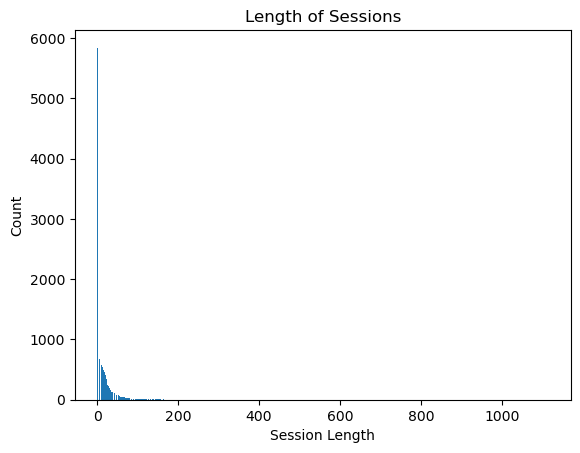

In [5]:
import matplotlib.pyplot as plt

# Group the data by session ID and calculate the count of items in each session
session_lengths = data_clean.groupby('InvoiceNo')['StockCode'].count()

# Count the frequency of each session length
length_counts = session_lengths.value_counts()

# Sort the lengths in ascending order
lengths = sorted(length_counts.index)

# Create a bar chart
plt.bar(lengths, length_counts)
plt.xlabel('Session Length')
plt.ylabel('Count')
plt.title('Length of Sessions')
plt.show()

In [6]:
# Calculate the average session length
average_length = session_lengths.mean()

# Find the longest session
longest_length = session_lengths.max()

print("Average Session Length:", average_length)
print("Longest Session Length:", longest_length)
plt.show()

Average Session Length: 20.923127413127414
Longest Session Length: 1114


In [7]:
unique_sessions = data_clean['InvoiceNo'].unique()
print("Number of unique sessions:", len(unique_sessions))

Number of unique sessions: 25900


In [8]:
unique_item_ids = data_clean['StockCode'].unique()
print(len(unique_item_ids))

4070


In [9]:
max_session_length = data_clean.groupby('InvoiceNo').size().max()
print(max_session_length)


1114


In [10]:
# create a dataset that w2v can train on
def create_w2v_data(df):
    sessions, session = [], []
    for index, value in df.iterrows():
        if index != 0:
            if str(value["InvoiceNo"]) == str(df.at[index-1, "InvoiceNo"]):
                session.append(str(value["StockCode"]))
            else:
                if len(session) != 0:
                    sessions.append(session)
                session = [str(value["StockCode"])]
        else:
            session.append(str(value["StockCode"]))
    return sessions

In [11]:
word_vc=create_w2v_data(data_clean)
# print(word_vc)

In [12]:
longest_session=max(data_clean['InvoiceNo'].str.len())


In [13]:
from gensim.models import Word2Vec
import numpy as np

# training the W2V model
model = Word2Vec(sentences=word_vc, 
                 window=longest_session, 
                 min_count=2, 
                 workers=4,
                 vector_size =100)
wv2=model

In [14]:
sequences = []
targets = []

for session in word_vc:
    if len(session) >= 6:
        sequences.append(session[:-1])  # Add first 5 items as sequence
        targets.append(session[-1])  # Add last item as target

sequences = np.array(sequences)
targets = np.array(targets)

print("Input sequences shape:", sequences.shape)
print("Target items shape:", targets.shape)

Input sequences shape: (15748,)
Target items shape: (15748,)


/tmp/ipykernel_1489054/3998252553.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)


In [15]:
def create_lstm_data(df):
    sequences = []
    targets = []
    session = []

    for index, value in df.iterrows():
        if index != 0:
            if str(value["InvoiceNo"]) == str(df.at[index-1, "InvoiceNo"]):
                session.append(str(value["StockCode"]))
            else:
                if len(session) >= 6:
                    for i in range(len(session) - 5):
                        sequences.append(session[i:i+5])  # Add 5-item sequence
                        targets.append(session[i+5])  # Add next item as target
                session = [str(value["StockCode"])]
        else:
            session.append(str(value["StockCode"]))

    return sequences, targets

In [16]:
sequences, targets = create_lstm_data(data_clean)
sequences = np.array(sequences)
targets = np.array(targets)

print("Input sequences shape:", sequences.shape)
print("Target items shape:", targets.shape)

Input sequences shape: (443600, 5)
Target items shape: (443600,)


In [17]:

# Create empty lists to store the vectorized sequences and targets
vectorized_sequences = []
vectorized_targets = []
print('JK')
# Convert sequences and targets to vectors using Word2Vec model
for sequence, target in zip(sequences, targets):
    sequence_vector = []
    for item in sequence:
        if item in model.wv:
            sequence_vector.append(model.wv[item])
        else:
            # Handle out-of-vocabulary items
            sequence_vector.append(np.zeros(model.vector_size))  # Assign zero vector for out-of-vocabulary items
    if target in model.wv:
        target_vector = model.wv[target]
    else:
        target_vector = np.zeros(model.vector_size)  # Assign zero vector for out-of-vocabulary target
    
    vectorized_sequences.append(sequence_vector)
    vectorized_targets.append(target_vector)

# Convert the lists to numpy arrays
vectorized_sequences = np.array(vectorized_sequences)
vectorized_targets = np.array(vectorized_targets)

print("Vectorized sequences shape:", vectorized_sequences.shape)
print("Vectorized targets shape:", vectorized_targets.shape)

JK
Vectorized sequences shape: (443600, 5, 100)
Vectorized targets shape: (443600, 100)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(5, 100)))  # Adjust the units and input_shape as needed
model.add(Dense(units=100))  # Adjust the units as needed

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Adjust the optimizer and loss function as needed

# Train the model
# history = model.fit(vectorized_sequences, vectorized_targets, epochs=1, batch_size=32)  # Adjust the epochs and batch_size as needed




13863/13863 [==============================] - 118s 9ms/step - loss: 0.2956


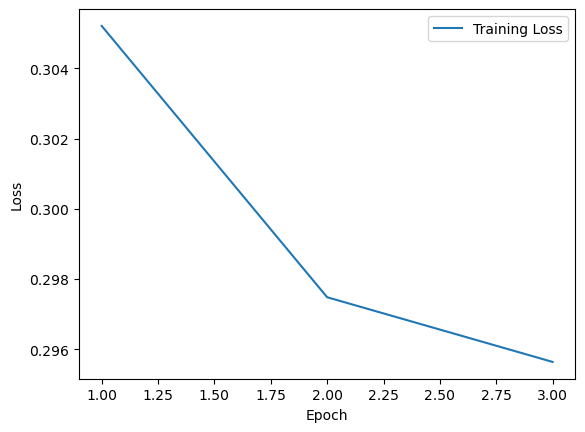

In [45]:
import numpy as np
import matplotlib.pyplot as plt

loss_values = []
val_loss_values = []

# Train the model and store the loss values
for epoch in range(3):
    history = model.fit(vectorized_sequences, vectorized_targets, epochs=1, batch_size=32)
    loss_values.append(history.history['loss'][0])
    # Optionally, calculate and store the validation loss
    # val_loss = model.evaluate(vectorized_sequences_val, vectorized_targets_val, verbose=0)
    # val_loss_values.append(val_loss)

# Plot the training and validation loss values
epochs = np.arange(1, 4)
plt.plot(epochs, loss_values, label='Training Loss')
# plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_sequences, vectorized_targets, test_size=0.2, random_state=42)
#model.fit(X_train, y_train, epochs=1, batch_size=32)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


2773/2773 [==============================] - 13s 4ms/step


# GRU

In [32]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(units=128, input_shape=(5, 100)))
model.add(Dense(units=100,activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

# # Evaluate the model on test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()

Epoch 1/2
10703/11090 [===========================>..] - ETA: 3s - loss: -10267.7090 - accuracy: 0.0993

In [22]:
import numpy as np

def calculate_mrr(y_true, y_pred):
    mrr = 0
    for true_items, pred_items in zip(y_true, y_pred):
        rank = 0
        for i, item in enumerate(pred_items, 1):
            if np.all(item == true_items):
                rank = 1/i
                break
        mrr += rank
    mrr /= len(y_true)
    return mrr

def calculate_recall(y_true, y_pred, k):
    recalls = []
    for true_item, pred_items in zip(y_true, y_pred):
        pred_items = pred_items[:k]
        recall = np.sum(np.isin(true_item, pred_items)) / len(true_item)
        recalls.append(recall)
    recall_at_k = np.mean(recalls)
    return recall_at_k

y_true = y_test 
y_pred = model.predict(X_test)
mrr = calculate_mrr(y_true, y_pred)
recall_at_5 = calculate_recall(y_true, y_pred, 5)
recall_at_10 = calculate_recall(y_true, y_pred, 10)
recall_at_20 = calculate_recall(y_true, y_pred, 20)

print("MRR:", mrr)
print("Recall@5:", recall_at_5)
print("Recall@10:", recall_at_10)
print("Recall@20:", recall_at_20)


2773/2773 [==============================] - 13s 4ms/step
MRR: 0.00016907123534715962
Recall@5: 0.00016907123534715962
Recall@10: 0.00016907123534715962
Recall@20: 0.00016907123534715962


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

2773/2773 [==============================] - 12s 4ms/step
Mean Squared Error (MSE): 0.4629245255472892
Root Mean Squared Error (RMSE): 0.680385571236846
Mean Absolute Error (MAE): 0.510020817865824
R-squared (R2): -0.08413327437619528


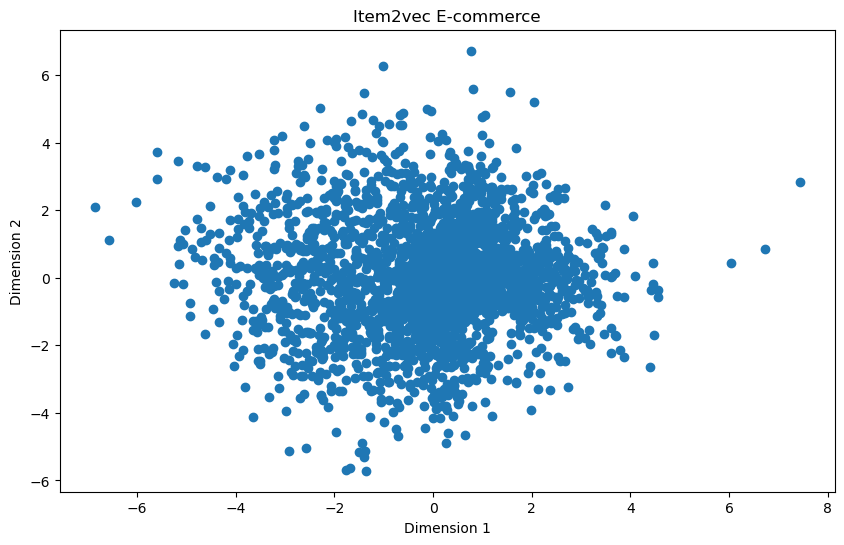

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

vocab = list(wv2.wv.key_to_index) 
vectors = np.array([model.wv[word] for word in vocab])
# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Item2vec E-commerce')
plt.show()

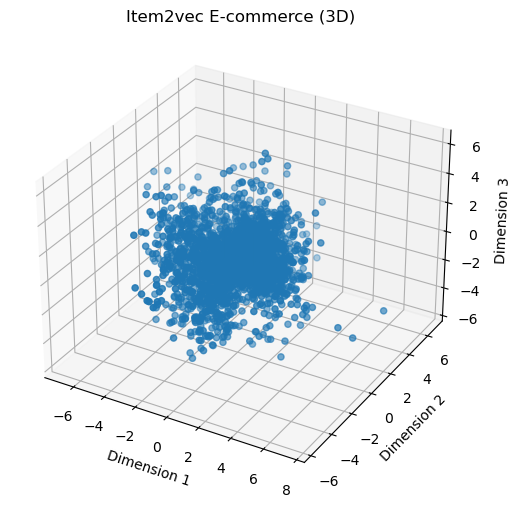

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have trained the Word2Vec model and obtained the word vectors

# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

# Plotting the results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2])
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Item2vec E-commerce (3D)')
plt.show()


Epoch 1/2
11090/11090 [==============================] - 91s 8ms/step - loss: 0.2975 - val_loss: 0.2977
Epoch 2/2
11090/11090 [==============================] - 90s 8ms/step - loss: 0.2964 - val_loss: 0.2967


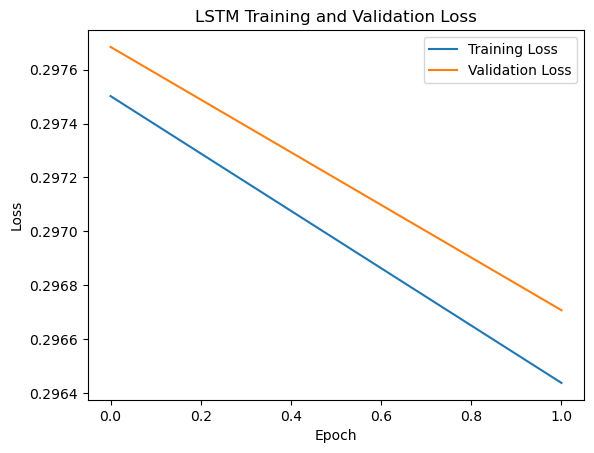

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()